In [2]:
library(dplyr)
library(tidyverse)
library(magrittr)
library(ggplot2)
library(corrr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   2.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




### Phase A. Initial data analysis

**1.1 Data processing, wrangling, transformation**

1.1-1&2 Determine the number of missing values per variable and per record, and deciding rules for exclusion of variables and records based on frequency of missing values. Decide if imputation might be used for some variables with missing values.

In [3]:
# 1.1 Data processing, wrangling, transformation
# Original dataset import 
star_original<-read.csv("/Users/apple/Desktop/LastTerm_UBC_2022_W2/STAT447B/GroupProject/Rdata/star_classification.csv",header=T)


Prune NA values in u, g & z

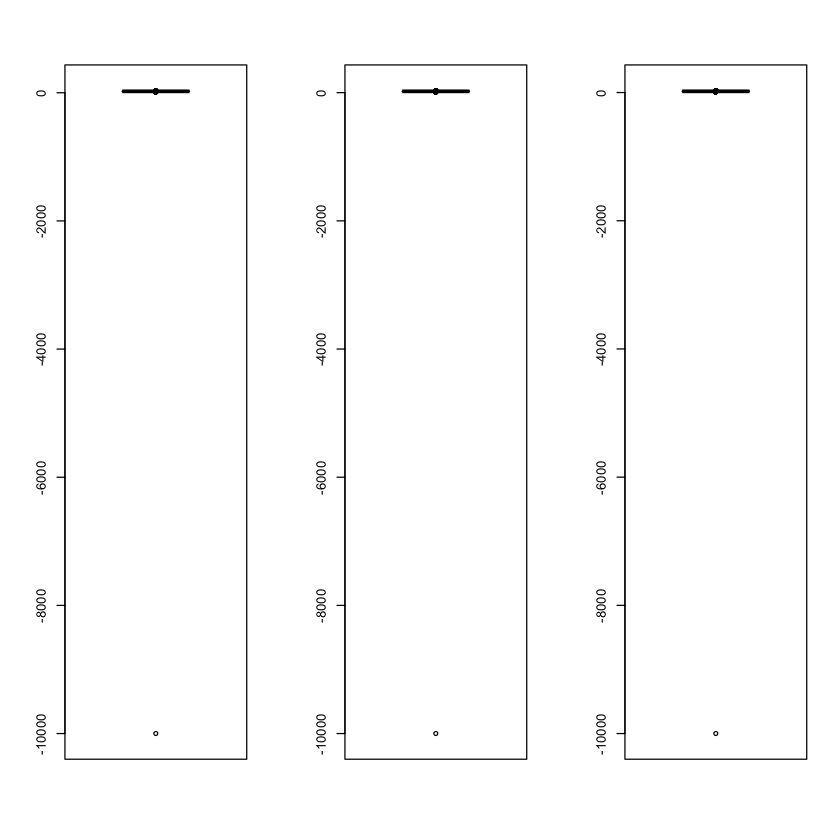

In [4]:
par(mfrow=c(1,3)) 
boxplot(star_original$u)
boxplot(star_original$g)
boxplot(star_original$z)

In [5]:
which.min(star_original$u)

[1] 79544

In [6]:
# confirm the extreme value is a NA(-9999)
star_original[79544,]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>
79544,1.237649e+18,224.0065,-0.6243039,-9999,-9999,18.1656,18.01675,-9999,752,301,2,537,3.731277e+18,STAR,8.934163e-05,3314,54970,162


In [7]:
# prune extreme value
star_original<-star_original[-79544,]

1.1-3. Transform variables if necessary in order to do **pairwise scatterplots** of quantitative variables and **side-by-side boxplots** of a continuous quantitative variable versus a categorical variable. 

In [8]:
# cos transformation on variables w/ unit as angle
# Scaling all numeric variables, then trunk at 5 digits
# categorical variables to factor
star <- star_original %>% mutate(
  alpha = cos(alpha),
  delta = cos(delta),
  obj_ID = round(scale(obj_ID, center = TRUE, scale = TRUE), 5),
  u = round(scale(u, center = TRUE, scale = TRUE), 5),
  g = round(scale(g, center = TRUE, scale = TRUE), 5),
  r = round(scale(r, center = TRUE, scale = TRUE), 5),
  i = round(scale(i, center = TRUE, scale = TRUE), 5),
  z = round(scale(z, center = TRUE, scale = TRUE), 5),
  run_ID = round(scale(run_ID, center = TRUE, scale = TRUE), 5),
  spec_obj_ID = round(scale(spec_obj_ID, center = TRUE, scale = TRUE), 5),
  redshift = round(scale(redshift, center = TRUE, scale = TRUE), 5),
  field_ID = round(scale(field_ID, center = TRUE, scale = TRUE), 5),
  plate = round(scale(plate, center = TRUE, scale = TRUE), 5),
  MJD = round(scale(MJD, center = TRUE, scale = TRUE), 5),
  fiber_ID = round(scale(fiber_ID, center = TRUE, scale = TRUE), 5),
  cam_col = factor(cam_col),
  class = factor(class)
)


In [9]:
# 1.1-4 time variables: N/A

#1.1-5 After appropropriate transforms and handling of missing values,
# look at scatterplots or side-by-side boxplots or tables of each variable with response
# (depends on whether explanatory and response variables are categorical or continuous quantitative).
# Since the response variable is categorical, side-by-side box plots with response variable- class on x-axis are carried out.


In [10]:
# re-order dataset by putting categorical variable and response variable to last
star <- star[, c(1:10, 12, 13, 15:18, 11, 14)]

In [11]:
# pick a subset to plot, due to large datasize
set.seed(447)
n <- star %>% nrow()
star_subset <- sample_n(star, size = n * 0.1)

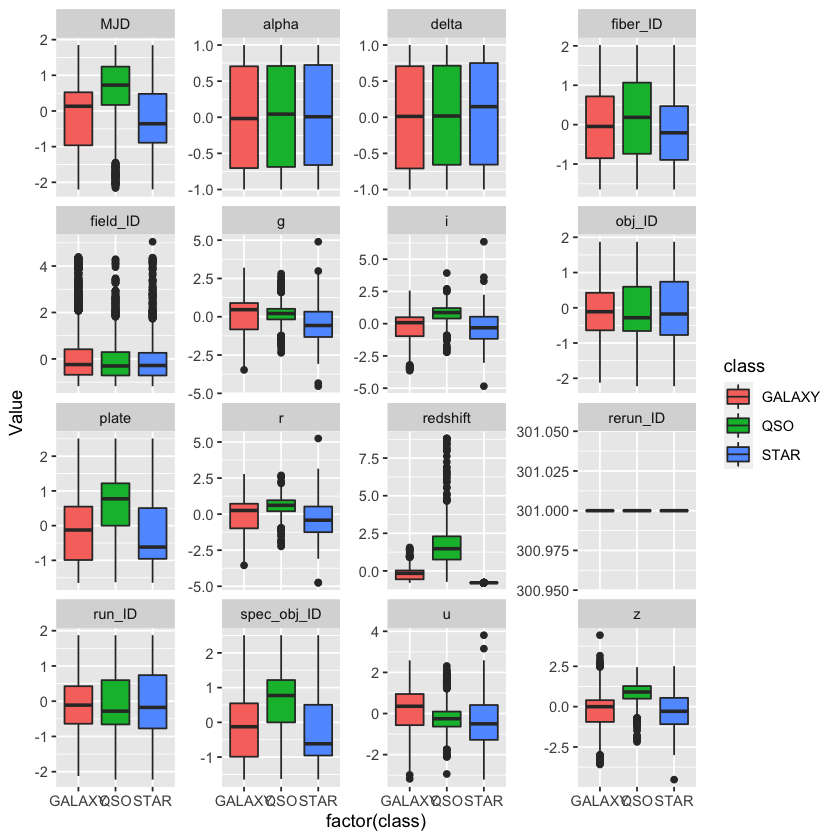

In [12]:
#boxplot of all variables
box_plot <- star_subset %>%
  select(obj_ID:fiber_ID, class) %>%
  pivot_longer(!class, names_to = "Measure", values_to = "Value") %>%
  ggplot(aes(x = factor(class), y = Value, fill = class)) +
  geom_boxplot() + facet_wrap(~ Measure, scales = "free_y", ncol = 4);

box_plot

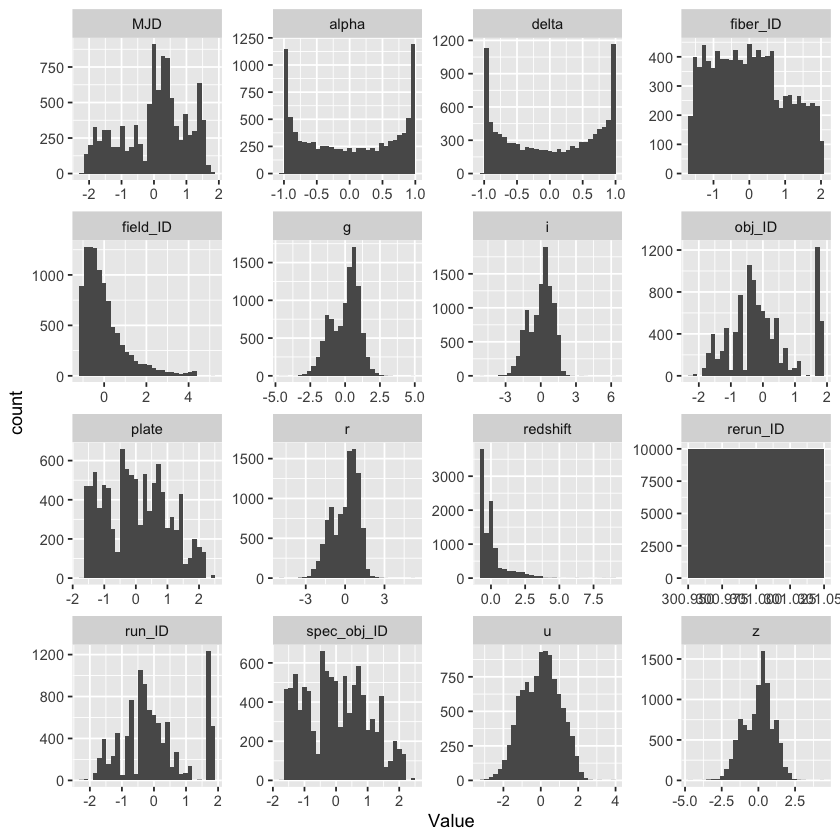

In [13]:
#histograms of all variables
hist_plot <- star_subset %>%
  select(obj_ID:fiber_ID) %>%
  pivot_longer(everything(), names_to = "Measure", values_to = "Value") %>%
  ggplot(aes(x = Value)) +
  geom_histogram(bins = 30) + facet_wrap(~ Measure, ncol = 4,scales = "free");

hist_plot

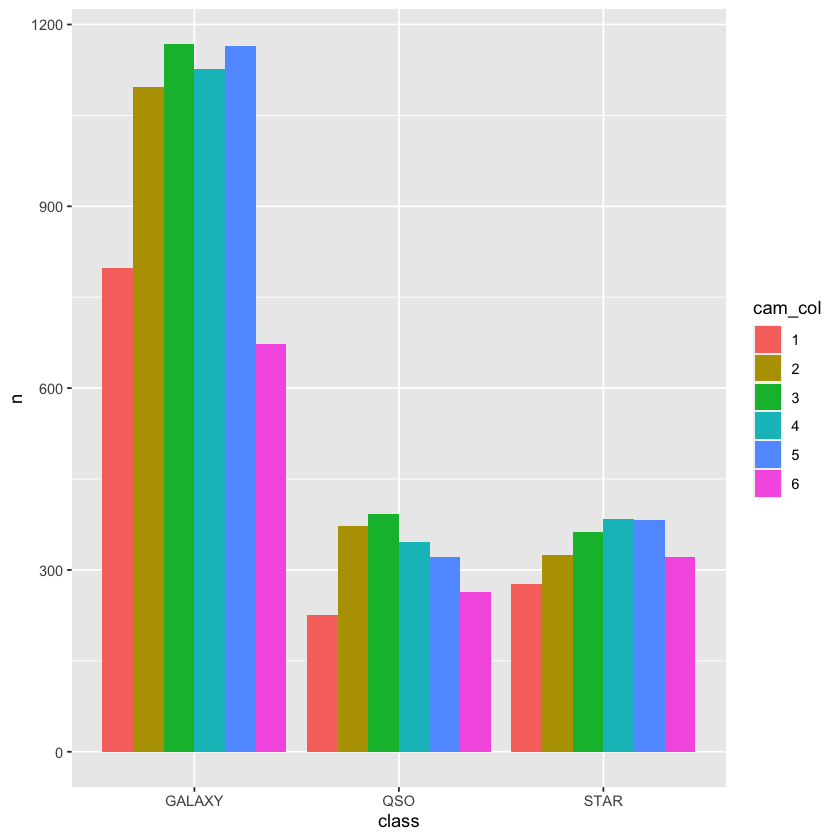

In [14]:
# clustered bar plot for cam_col
bar_plot <- star_subset %>%
  group_by(class) %>%
  count(cam_col) %>%
  ggplot(aes(x = class, y = n, fill = cam_col)) +
  geom_bar(position = "dodge", stat = "identity")

bar_plot

**From the plots above, concluding binning is necessary for field_ID and run_ID**

In [15]:
# Binning field_ID & run_ID
# Since scaling and centering has been performed, so find bin breaks by quantile.
paste("field_ID")
paste(summary(star$field_ID))
paste("run_ID")
paste(summary(star$run_ID))

[1] "field_ID"

[1] "Min.   :-1.1753  " "1st Qu.:-0.6988  " "Median :-0.2693  "
[4] "Mean   : 0.0000  " "3rd Qu.: 0.3683  " "Max.   : 5.3881  "

[1] "run_ID"

[1] "Min.   :-2.2254400  " "1st Qu.:-0.6588200  " "Median :-0.1493300  "
[4] "Mean   :-0.0000002  " "3rd Qu.: 0.4298800  " "Max.   : 1.8733300  "

In [16]:
#create variable breaks
field_id_breaks <- c(-1.18, -0.774, -0.45, -0.06, 0.58, 5.4)
run_id_breaks <- c(-2.23, -0.831, -0.327, 0.048, 0.8, 1.9)

# combining
breaks <- rbind(field_id_breaks, run_id_breaks)

In [17]:
#binning function
bin <- function(dataset, breaks) {
  bindata <- as_tibble(dataset) %>%
    dplyr::mutate(fieldbin = cut(field_ID, breaks[1,]),
                  runbin = cut(run_ID, breaks[2,])) %>%
    dplyr::select(class, field_ID, run_ID, fieldbin, runbin)
  bindata
}

In [18]:
# apply function
bin_result <- bin(star, breaks)
summary(bin_result)

    class          field_ID.V1          run_ID.V1                 fieldbin    
 GALAXY:59445   Min.   :-1.17529   Min.   :-2.2254400   (-1.18,-0.774]:20181  
 QSO   :18961   1st Qu.:-0.69880   1st Qu.:-0.6588200   (-0.774,-0.45]:19832  
 STAR  :21593   Median :-0.26929   Median :-0.1493300   (-0.45,-0.06] :19963  
                Mean   : 0.00000   Mean   :-0.0000002   (-0.06,0.58]  :20097  
                3rd Qu.: 0.36826   3rd Qu.: 0.4298800   (0.58,5.4]    :19926  
                Max.   : 5.38813   Max.   : 1.8733300                         
             runbin     
 (-2.23,-0.831] :20019  
 (-0.831,-0.327]:19590  
 (-0.327,0.048] :20341  
 (0.048,0.8]    :20116  
 (0.8,1.9]      :19933  
                        

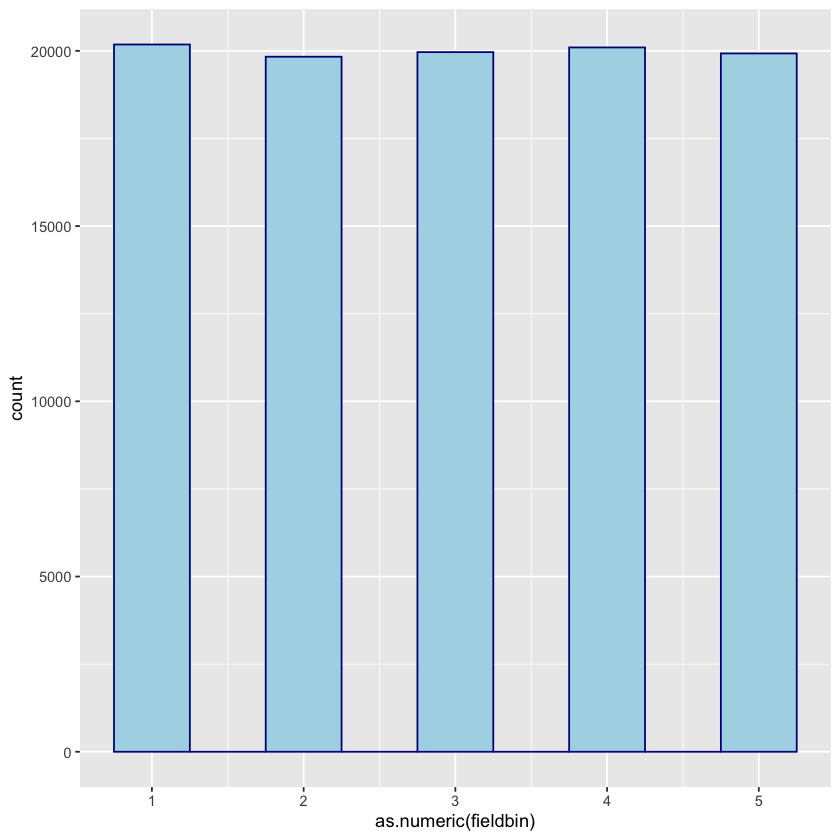

In [19]:
#This barplot shows that the number of observations in each bin are distributed quite evenly
ggplot(bin_result[, c("field_ID", "fieldbin")], aes(x = as.numeric(fieldbin))) +
  geom_histogram(color = "darkblue", fill = "lightblue", binwidth = 0.5)



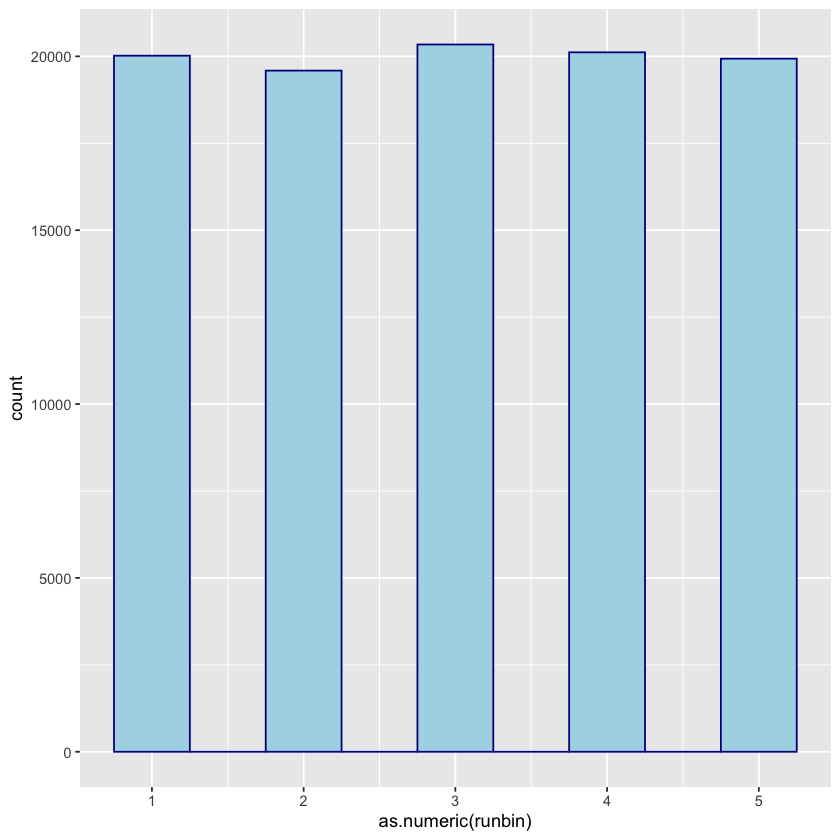

In [20]:
#same with this barpolot
ggplot(bin_result[, c("run_ID", "runbin")], aes(x = as.numeric(runbin))) +
  geom_histogram(color = "darkblue", fill = "lightblue", binwidth = 0.5)

In [21]:
#combined binning result to dataset as separate variables, and change type to factor
star <- cbind(star, bin_result[, 4:5])
star <- star %>%
  mutate(fieldbin = factor(star$fieldbin), 
         runbin = factor(star$runbin))

In [22]:
# re-order dataset by putting categorical variable and response variable to last
star <- star[, c(1:17, 19, 20, 18)]
# star %>% colnames()

In [23]:
# rerun_ID should be dropped since it only has same value for all observations
star <- star[, -10]

In [24]:
# field_ID and run_ID should be replaced by their bins
star <- star[, -c(9,10)]

In [25]:
# redo subset w/ same seed
set.seed(447)
n <- star %>% nrow()
star_subset <- sample_n(star, size = n * 0.1)

1.1-4 time variables: N/A

1.1-5 After appropropriate transforms and handling of missing values, look at scatterplots or side-by-side boxplots or tables of each variable with response (depends on whether explanatory and response variables are categorical or continuous quantitative).<br/>

Since the response variable is categorical, side-by-side box plots with response variable- class on x-axis are carried out.

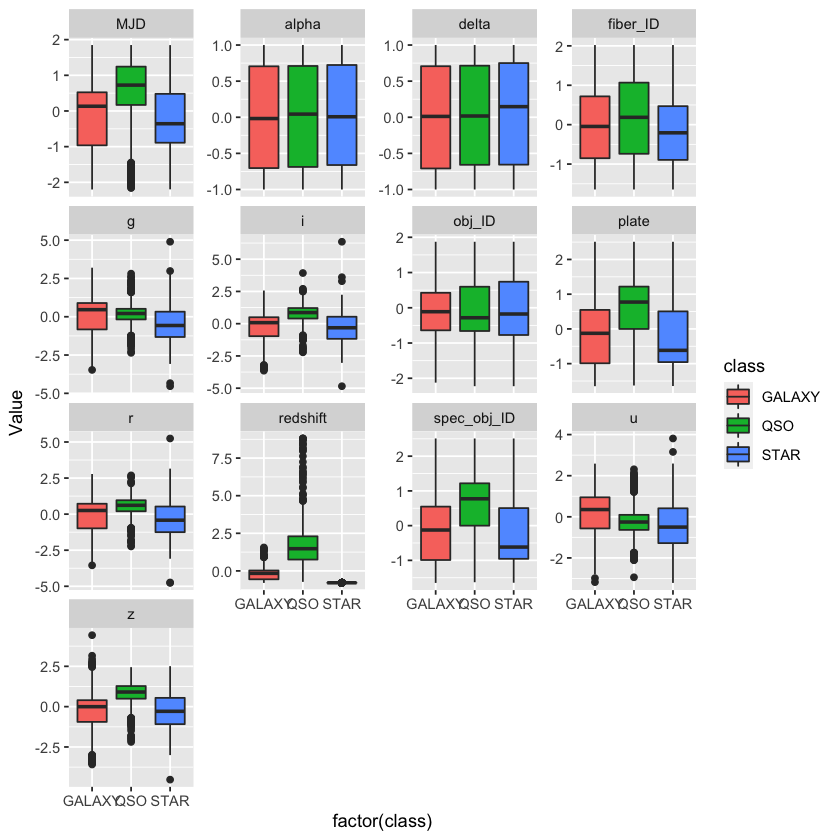

In [26]:
# box_plot<-star_subset%>%
# select(alpha:obj_ID,class)%>%pivot_longer(!class, names_to = "Measure",values_to = "Value")%>%
#             ggplot(aes(x = class, y = Value))+
#             geom_boxplot(fill='#A4A4A4', color="black")+facet_wrap( ~ Measure, scales="free_y", ncol = 4);
# box_plot

box_plot<-star_subset %>%
  select(obj_ID:fiber_ID, class) %>%
  pivot_longer(!class, names_to = "Measure",values_to = "Value") %>%
  ggplot(aes(x = factor(class), y = Value, fill = class)) +
  geom_boxplot() + facet_wrap( ~ Measure, scales="free_y", ncol = 4);
box_plot

In [27]:
# create table for bar plot
bp <- star_subset %>% group_by(class) %>% count(cam_col) 

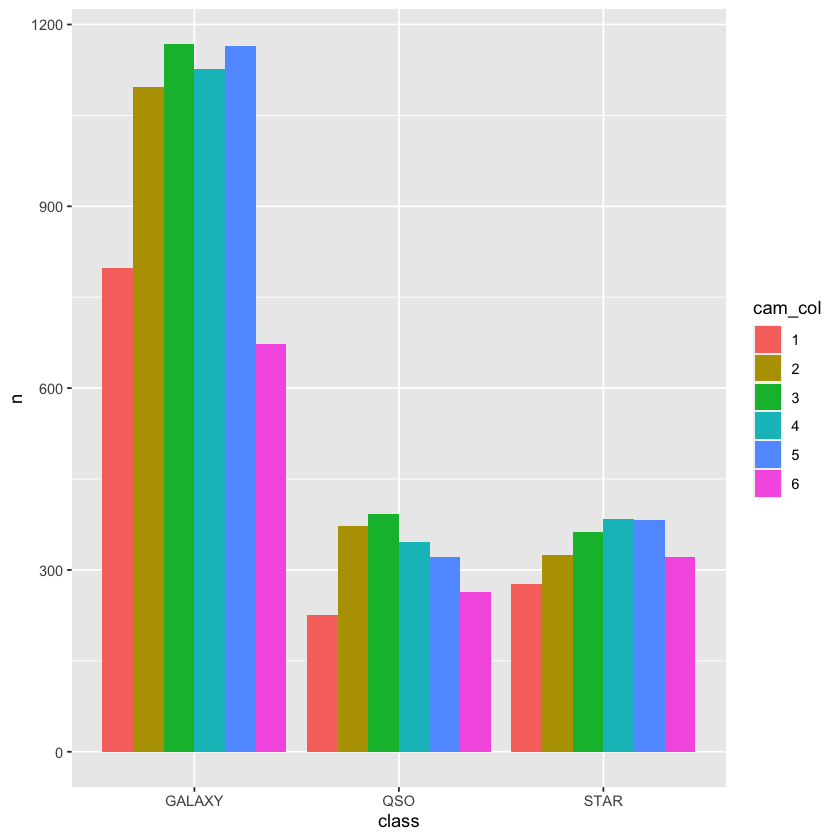

In [28]:
bar_plot<-star_subset %>% 
    group_by(class) %>% 
    count(cam_col) %>% 
    ggplot(aes(x = class, y = n,fill = cam_col)) + 
    geom_bar(position = "dodge", stat = "identity")
bar_plot

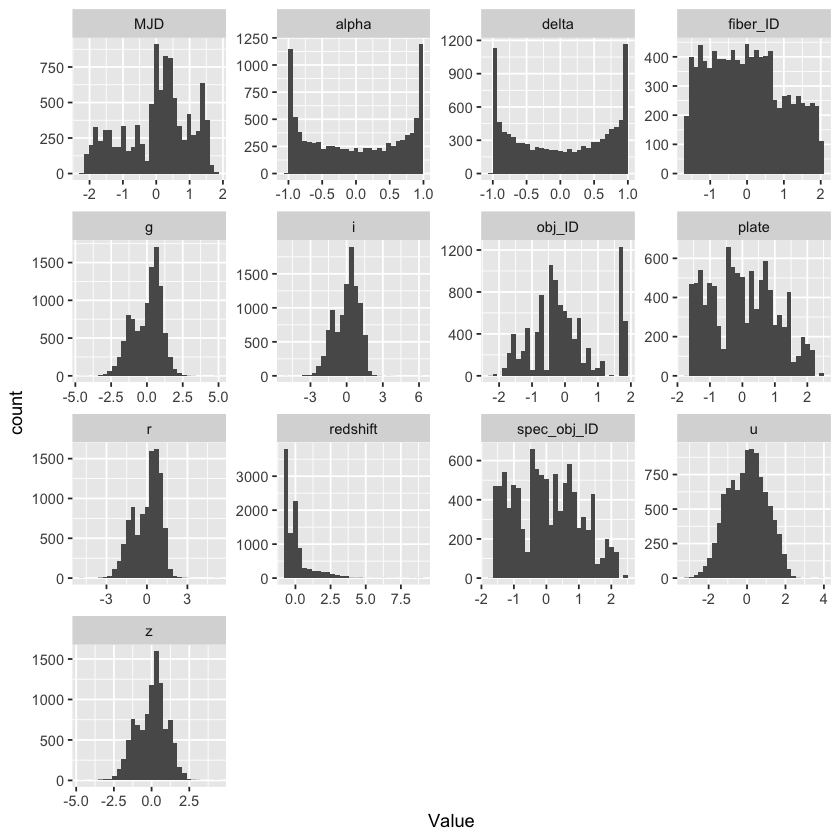

In [29]:
# histogram of each feature 
hist_plot <- star_subset %>%
  select(obj_ID:fiber_ID) %>%
  pivot_longer(everything(), names_to = "Measure", values_to = "Value") %>%
  ggplot(aes(x = Value)) +
  geom_histogram(bins = 30) + facet_wrap(~ Measure, ncol = 4,scales = "free");
hist_plot



1.1-6 6. Obtain Spearman rank correlations for each explanatory variable with the responsevariable, if the response is quantitative or ordinal categorical.

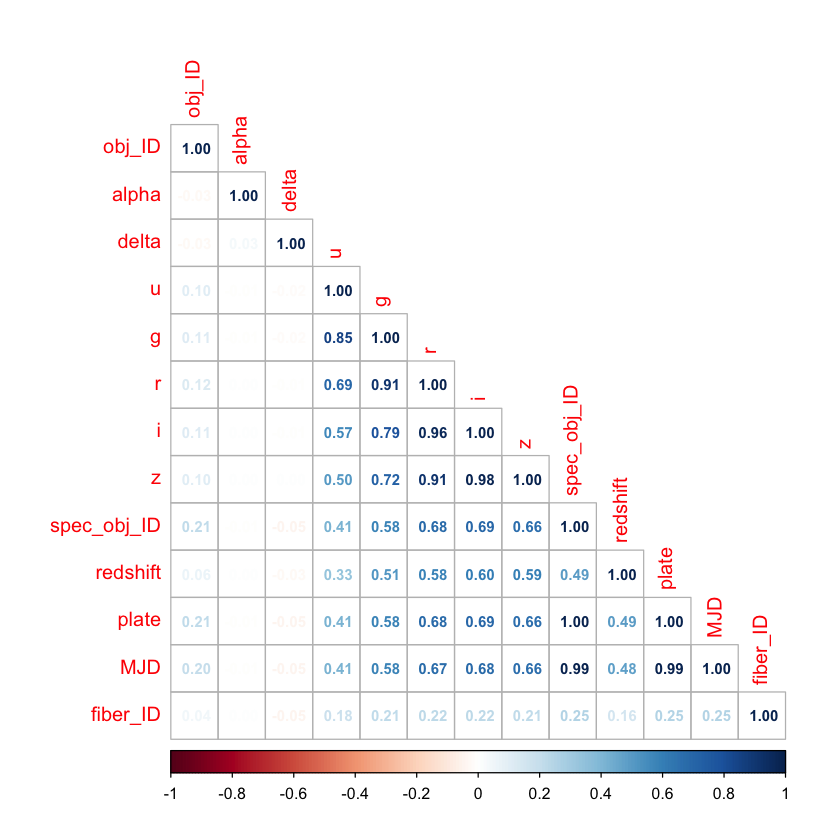

In [30]:
# plotting only numerical features
cor <- cor(star_subset[, -c(14:17)],
           method = "spearman")
corrplot::corrplot(round(cor, 2), method = "number", type = "lower", number.cex = 0.75)

In [31]:
# drop features due to high correlation
# Dataset after pruning
star <- star[, c(2, 3, 4, 7, 10:17 )]
star_subset <- star_subset[, c(2, 3, 4, 7, 10:17 )]

In [32]:
# save the transformatted data as star_trans
write.csv(star,'/Users/apple/Desktop/LastTerm_UBC_2022_W2/STAT447B/GroupProject/Rdata/PhaseA_star.csv')
write.csv(star_subset,'/Users/apple/Desktop/LastTerm_UBC_2022_W2/STAT447B/GroupProject/Rdata/PhaseA_star_subset.csv')
